In [1]:
!pip install torch_geometric
!pip install ogb

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear


import torchvision
import torchvision.transforms as transforms

import sklearn.metrics as metrics

import torch_geometric.nn as pyg_nn
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import TUDataset

import ogb
from ogb.nodeproppred import PygNodePropPredDataset
from ogb.nodeproppred import Evaluator

import gc
import psutil

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch_scatter/_version_cpu.so, 0x0006): symbol not found in flat namespace '__ZN3c1017RegisterOperatorsD1Ev'
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: dlopen(/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch_cluster/_version_cpu.so, 0x0006): symbol not found in flat namespace '__ZN3c1017RegisterOperatorsD1Ev'
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/Library/Frameworks/Python.framework/Versions/3.11/l

In [3]:
print(ogb.__version__)

1.3.6


In [4]:
# Research paper dataset
dataset = PygNodePropPredDataset(name = "ogbn-arxiv")

split_idx = dataset.get_idx_split()
train_idx, valid_idx, test_idx = split_idx["train"], split_idx["valid"], split_idx["test"]
graph = dataset[0] # pyg graph object

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ogb/nodeproppred/dataset_pyg.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, 

In [5]:
# Number of training points
train_idx.shape

torch.Size([90941])

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39])


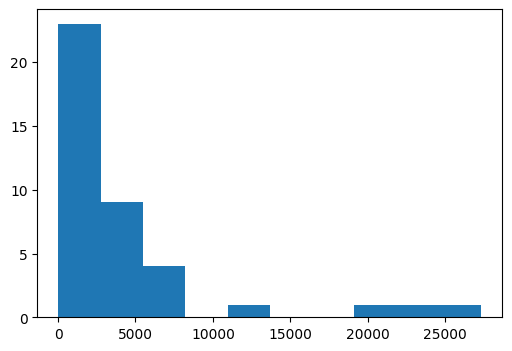

In [6]:
# Number of y labels
classes, counts = torch.unique(graph.y, return_counts=True)
print(classes)
plt.figure(figsize=(6,4))
plt.hist(counts)
plt.show()

In [7]:
evaluator = Evaluator(name = "ogbn-arxiv")
print(evaluator.expected_input_format)
print(evaluator.expected_output_format)

==== Expected input format of Evaluator for ogbn-arxiv
{'y_true': y_true, 'y_pred': y_pred}
- y_true: numpy ndarray or torch tensor of shape (num_nodes num_tasks)
- y_pred: numpy ndarray or torch tensor of shape (num_nodes num_tasks)
where y_pred stores predicted class label (integer),
num_task is 1, and each row corresponds to one node.

==== Expected output format of Evaluator for ogbn-arxiv
{'acc': acc}
- acc (float): Accuracy score averaged across 1 task(s)



In [8]:
# from torch_geometric.loader import DataLoader

# # Create a single Data object with train/val/test masks
# full_data = Data(
#     x=graph.x,
#     y=graph.y,
#     edge_index=graph.edge_index,
#     train_mask=torch.zeros(graph.x.size(0), dtype=torch.bool),
#     val_mask=torch.zeros(graph.x.size(0), dtype=torch.bool),
#     test_mask=torch.zeros(graph.x.size(0), dtype=torch.bool)
# )

# # Set the masks
# full_data.train_mask[train_idx] = True
# full_data.val_mask[valid_idx] = True
# full_data.test_mask[test_idx] = True

In [9]:
def print_memory_usage():
    # Get the process using psutil
    process = psutil.Process()

    # Get memory info in bytes, convert to GB
    memory_use = process.memory_info().rss / 1024 / 1024 / 1024  # Convert bytes to GB

    # Get system memory info
    system_memory = psutil.virtual_memory()

    print(f"Process Memory Usage: {memory_use:.2f}GB")
    print(f"System Memory: {system_memory.used/1024/1024/1024:.2f}GB used out of {system_memory.total/1024/1024/1024:.2f}GB")
    print(f"Memory Percentage Used: {system_memory.percent}%")

In [10]:
def monitor_resources():
    process = psutil.Process()
    memory_use = process.memory_info().rss / 1024 / 1024 / 1024
    # print(f"Memory Use: {memory_use:.2f}GB")
    if memory_use > 6:  # Alert if using more than 6GB
        print("Warning: High memory usage")

In [11]:
class GCNModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=4, dropout=0.5, task='node'):
        super(GCNModel, self).__init__()

        # initialize Module Lists
        self.task = task
        self.convs = nn.ModuleList()
        self.batch_norms = nn.ModuleList()

        # Append input layer
        self.convs.append(self.build_conv_model(input_dim, hidden_dim))
        self.batch_norms.append(nn.BatchNorm1d(hidden_dim))

        for _ in range(num_layers-1):
            self.convs.append(self.build_conv_model(hidden_dim, hidden_dim))
            self.batch_norms.append(nn.BatchNorm1d(hidden_dim))

        # post-message passing Output Layer
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim))

        if not (self.task == 'node' or self.task == 'graph'):
            raise RuntimeError('Unknown task')

        self.dropout = dropout
        self.num_layers = num_layers

    def build_conv_model(self, input_dim, hidden_dim):
        # refer to pytorch geometric nn module for different implementation of GNNs.
        if self.task == 'node':
            return pyg_nn.GCNConv(input_dim, hidden_dim)
        else:
            return pyg_nn.GINConv(nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                                nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        if data.num_node_features == 0:
            x = torch.ones(data.num_nodes, 1)

        for i in range(self.num_layers):
            identity = x
            x = self.convs[i](x, edge_index)
            x = self.batch_norms[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            if i > 0 and x.size(-1) == identity.size(-1):
                x = x + identity

        x = self.post_mp(x)

        return x, F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        # Calculate class weights based on distribution
        class_counts = torch.bincount(label)
        class_weights = 1.0 / class_counts.float()
        class_weights = class_weights / class_weights.sum() * len(class_weights)
        return F.nll_loss(pred, label, weight=class_weights)

In [12]:
def train(model, data, optimizer, split_idx, num_layers=4, task='node', device='cpu'):
  # Clear memory cache
  if torch.cuda.is_available():
      torch.cuda.empty_cache()
  gc.collect()  # Garbage collection

  # Train the model
  model.train()
  optimizer.zero_grad()

  # Forward pass
  _, out = model(data)

  train_idx = split_idx['train']
  loss = F.nll_loss(out[train_idx], data.y.squeeze(1)[train_idx])

  # Backward pass
  loss.backward()
  optimizer.step()

  return loss.item()

In [13]:
@torch.no_grad()
def test(model, data, evaluator, split_idx):
  model.eval()

  _, out = model(data)
  y_pred = out.argmax(dim=1, keepdim=True) # Convert to required shape [num_nodes, 1]

  train_acc = evaluator.eval({
        'y_true': data.y[split_idx['train']],
        'y_pred': y_pred[split_idx['train']],
    })['acc']
  valid_acc = evaluator.eval({
        'y_true': data.y[split_idx['valid']],
        'y_pred': y_pred[split_idx['valid']],
    })['acc']
  test_acc = evaluator.eval({
        'y_true': data.y[split_idx['test']],
        'y_pred': y_pred[split_idx['test']],
    })['acc']

  return train_acc, valid_acc, test_acc

In [14]:
# Hyperparameters
dataset_name = 'ogbn-arxiv'
hidden_dim = 256
task = 'node'
num_layers = 5
learning_rate = 0.001
weight_decay = 1e-5
num_epochs = 300

In [15]:
def main():
    evaluator = Evaluator(name = dataset_name)

     # Get dataset info first
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dataset = PygNodePropPredDataset(name='ogbn-arxiv')
    data = dataset.to(device)
    num_classes = dataset.num_classes

    # Get split indices from the dataset
    split_idx = dataset.get_idx_split()

     # Convert split indices to masks if needed
    num_nodes = data.x.size(0)
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    valid_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    train_mask[split_idx['train']] = True
    valid_mask[split_idx['valid']] = True
    test_mask[split_idx['test']] = True

    split_idx = {
        'train': train_mask,
        'valid': valid_mask,
        'test': test_mask
        }

    # initialize model
    model = GCNModel(
        max(data.num_node_features, 1),
        hidden_dim = hidden_dim,
        output_dim = num_classes,
        task=task,
        num_layers = num_layers)

    opt = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, 'max', patience=10)

    best_val_acc = 0
    final_test_acc = 0

    for epoch in range(num_epochs):
        # Training
        loss = train(model, data, opt, split_idx)

        # Evaluation
        train_acc, val_acc, test_acc = test(model, data, evaluator, split_idx)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            final_test_acc = test_acc
            torch.save(model.state_dict(), 'best_model.pt')

        if epoch % 20 == 0:
            print(f'Epoch: {epoch:02d}, '
                f'Loss: {loss:.4f}, '
                f'Train: {100*train_acc:.2f}%, '
                f'Val: {100*val_acc:.2f}%, '
                f'Test: {100*test_acc:.2f}%')
        if epoch % 50 == 0:
            print_memory_usage()
            monitor_resources()

    print(f'Final Test: {100*final_test_acc:.2f}%')

In [16]:
main()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ogb/nodeproppred/dataset_pyg.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, 

Epoch: 00, Loss: 3.9681, Train: 1.57%, Val: 3.19%, Test: 5.12%
Process Memory Usage: 0.58GB
System Memory: 2.73GB used out of 8.00GB
Memory Percentage Used: 48.0%
Epoch: 20, Loss: 2.1592, Train: 37.01%, Val: 34.31%, Test: 26.21%
Epoch: 40, Loss: 1.7960, Train: 53.35%, Val: 52.26%, Test: 45.66%
Process Memory Usage: 0.56GB
System Memory: 2.48GB used out of 8.00GB
Memory Percentage Used: 43.0%
Epoch: 60, Loss: 1.6425, Train: 57.52%, Val: 56.13%, Test: 50.36%
Epoch: 80, Loss: 1.5548, Train: 59.42%, Val: 57.77%, Test: 51.90%
Epoch: 100, Loss: 1.4966, Train: 60.67%, Val: 58.58%, Test: 52.65%
Process Memory Usage: 0.14GB
System Memory: 1.91GB used out of 8.00GB
Memory Percentage Used: 47.0%
Epoch: 120, Loss: 1.4527, Train: 61.79%, Val: 59.35%, Test: 53.20%
Epoch: 140, Loss: 1.4200, Train: 62.53%, Val: 59.94%, Test: 53.95%
Process Memory Usage: 0.55GB
System Memory: 2.32GB used out of 8.00GB
Memory Percentage Used: 42.5%
Epoch: 160, Loss: 1.3896, Train: 63.19%, Val: 60.33%, Test: 54.30%
Epoch